Clase 12
===

Objetivos

1. Visualización de distribución de flujos
2. Eliminación de flujos
3. Agregar restricciones
4. Visualizar datos usando heatmaps.

1. Visualización de distribución de flujos
======================


!Ehh ya puedo calcular flujos metabólios! Pero ahora quiero hacer un dibujos bonitos :( 

Para esto necesitas una representación gráfica de las rutas metabólicas de interés en la cual podamos incorporar información de los flujos calculados usando cobrapy. La manera más facil de hacer esto es a través de [Escher](https://escher.readthedocs.io/en/latest/index.html). Lo puedes instalar con el comando:

``` python
pip install escher
```

Ilustremos su uso con la red de *Escherichia coli*. Para esto visita la página de [Escher](https://escher.readthedocs.io/en/latest/index.html) y descarga el gráfico del metabolismo central de *E coli* (se llama 'e_coli_core.Core metabolism').

In [1]:
import cobra
import cobra.test
from escher import Builder

# Calcular los flujos metabólicos
model = cobra.test.create_test_model("ecoli")
solution = model.optimize()
# Guarda los flujos metabólicos en un diccionario llamado fluxes
fluxes={}
for i,row in solution.fluxes.iteritems():
    fluxes[i] = row
# Cargamos una represanción gráfica del metabolismo central de Ecoli 
# en la cuales el color de los enlaces depende del valor de su flux
b = Builder(map_name="e_coli_core.Core metabolism",reaction_data=fluxes)
b.display_in_notebook()

¿No te gustaron los colores? Bueno, aquí hay otra opción

In [2]:
b = Builder(map_name="e_coli_core.Core metabolism",
                   reaction_data=fluxes,
                   # change the default colors
                   reaction_scale=[{'type': 'min', 'color': '#cccccc', 'size': 4},
                                   {'type': 'mean', 'color': '#0000dd', 'size': 20},
                                   {'type': 'max', 'color': '#ff0000', 'size': 40}],
                   # only show the primary metabolites
                   hide_secondary_metabolites=True)
b.display_in_notebook()

2. Eliminación de flujos
========================

Supongamos que tienes datos de expresión genética que sugieren que los siguientes genes que expresan las enzimas que no están expresados:

In [3]:
reactions = [
'ALLULPE',
'PGI',
'M1PD',
'F6PP',
'G6PDA',
'F6PA',
'GF6PTA',
'FRUpts2pp',
'TKT2',
'SBTPD',
'FBP',
'PFK',
'MAN6PI',
'F6Pt6_2pp',
'TALA',
'HEX7']

Genial. Con esto podemos asignar el valor de zero a todas ellas, lo cual es algo bueno ya que reducimos los grados de libertad de la red metabólica.

In [4]:
model = cobra.test.create_test_model("ecoli")

deletedReactions = cobra.Model("reacciones_eliminadas")
for reaction in reactions:
    reaction = model.reactions.get_by_id(reaction)
    deletedReactions.add_reaction(reaction.copy())
    model.remove_reactions([reaction])


model.optimize()
model.summary()    

IN FLUXES        OUT FLUXES    OBJECTIVES
---------------  ------------  --------------------------
o2_e      0.681  h2o_e  0.681  Ec_biomass_i...  -2.49e-47
glc__D_e  0.341  ac_e   0.681
                 co2_e  0.681
                 h_e    0.681


Ups!!! Ahora no crece. ¿Qué paso? Mmmm, eliminaste una reacción que es necesaria para la generación de biomasa. Aún cuando las tecnologías acutales de medición de actividad genética (por ejemplo RNA-seq) nos pueden indicar  que una o más reacciones está apagadas no podemos estar completamente seguros. Para consiliar esto, utilizaremos la siguiente estrategia.

Minimizar

\begin{align}
\sum_i{c_iz_i} & 
\end{align}

Sujeto a:

\begin{align}
Sv &= 0 \\
v^* &\ge t \\
z_iLB_i \le &v_i \le UB_iz_i
\end{align}

En donde $z_i$ es una variable binaria asociada a cada flujo que consideremos pueda estar apagado. No te asustes, cobrapy ya tiene implementada un rutina para hacer esto: [gapfilling](https://cobrapy.readthedocs.io/en/latest/gapfilling.html#). A continuación como se usa:

In [5]:
from cobra.flux_analysis import gapfill

gapfill_sln = gapfill(model, deletedReactions, demand_reactions=False)
necessaryReactions=[]
for reaction in gapfill_sln[0]:
    print reaction.id
    necessaryReactions += [reaction.id]

F6PA
GF6PTA


Al parecer necesitas incorporar de vuelta $F6PA$ y $GF6PTA$ si quieres que haya generación de biomasa.

Ejercicio
----------

1. Incorpora las reacciones sugeridas por $gapfilling$ y comprueba si ahora la biomasa es mayor que cero.
2. Utilizar Escher para ver como cambia la distribución de flujos.


In [6]:
for reactionID in necessaryReactions:
    reaction = deletedReactions.reactions.get_by_id(reactionID)
    model.add_reactions([reaction])

solution = model.optimize()
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
o2_e      19.1       h2o_e  46.1   Ec_biomass_i...  0.947
nh4_e     10.2       co2_e  21.1
glc__D_e  10         h_e     8.7
pi_e       0.913
so4_e      0.239
k_e        0.185
fe2_e      0.0152
mg2_e      0.00821
ca2_e      0.00493
cl_e       0.00493
cu2_e      0.000671
mn2_e      0.000654
zn2_e      0.000323
ni2_e      0.000306
mobd_e     0.000122


In [7]:
fluxes_fewer={}
for i,row in solution.fluxes.iteritems():
    fluxes_fewer[i] = row
# Cargamos una represanción gráfica del metabolismo central de Ecoli 
# en la cuales el color de los enlaces depende del valor de su flux
b = Builder(map_name="e_coli_core.Core metabolism",reaction_data=fluxes_fewer)
b.display_in_notebook()

3. Agregar restricciones 
========================

Otra manera de reducir los grados de libertad de la red metabólica es agregar restricciones a, por ejemplo, la razon entre dos fluxes. Tomemos el caso del metabolito $ru5p__D_c$ el cual es consumido por las reacciones $RPE$ y $RPI$. Si la razon entre sus flujos es 5, podemos restringir el espacio solución de la siguiente manera:  

In [8]:
# Cargamos el modelo y agregamos la restriccion: RPE/RPI = 5
model = cobra.test.create_test_model("ecoli")

restriccion = model.problem.Constraint( model.reactions.RPE.flux_expression 
        - 5*model.reactions.RPI.flux_expression, lb=0, ub=0)
model.add_cons_vars(restriccion)



In [9]:
# Calculasmos los flujos y los graficamos
solution = model.optimize()
model.summary()
fluxes_fewer={}
for i,row in solution.fluxes.iteritems():
    fluxes_fewer[i] = row
# Cargamos una represanción gráfica del metabolismo central de Ecoli 
# en la cuales el color de los enlaces depende del valor de su flux
b = Builder(map_name="e_coli_core.Core metabolism",reaction_data=fluxes_fewer)
b.display_in_notebook()

IN FLUXES            OUT FLUXES            OBJECTIVES
-------------------  --------------------  ----------------------
glc__D_e  10         h2o_e         32.4    Ec_biomass_i...  0.469
o2_e       9.11      co2_e         16.2
nh4_e      5.65      h_e            5.48
pi_e       1.04      kdo2lipid4_e   0.292
so4_e      0.118
k_e        0.0915
fe2_e      0.00753
mg2_e      0.00407
ca2_e      0.00244
cl_e       0.00244
cu2_e      0.000332
mn2_e      0.000324
zn2_e      0.00016
ni2_e      0.000151
mobd_e     6.05e-05


4. Visualizar datos usando heatmaps
===================================

Ya hemos usado heatmpas cuando graficamos el cambio en la velocidad de producción de biomasa:

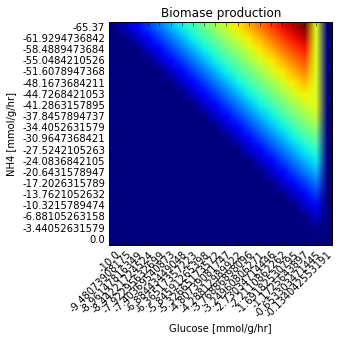

In [10]:
#Calcula prod_env
%matplotlib inline
from cobra.flux_analysis import production_envelope
prod_env = production_envelope(model, ["EX_glc_e", "EX_nh4_e"]) 

import numpy as np
import matplotlib.pyplot as plt
# Extrae los valores de cada flux sin repetirlos
xlabels=np.unique(prod_env["EX_glc_e"])
ylabels=np.unique(prod_env["EX_nh4_e"])


# Crea una matrix en donde guardar los valores de u
mat=np.zeros((20,20))
for i in range(20):
    mat[i,0:20]=prod_env["flux_maximum"][i*20:(i+1)*20]
    
#Crea un heatmap de la matriz
fig,ax=plt.subplots()
ax.set_xticks(np.arange(len(xlabels)))
ax.set_yticks(np.arange(len(ylabels)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)    
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Biomase production")
ax.set_ylabel("NH4 [mmol/g/hr]")
ax.set_xlabel("Glucose [mmol/g/hr]")
mat[np.isnan(mat)]=0
im=ax.imshow(mat)

Para agregarle una barra de color, solo es necesario agregar dos comandos 

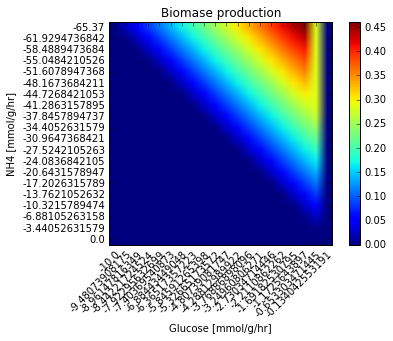

In [11]:
import numpy as np
import matplotlib.pyplot as plt
# Extrae los valores de cada flux sin repetirlos
xlabels=np.unique(prod_env["EX_glc_e"])
ylabels=np.unique(prod_env["EX_nh4_e"])


# Crea una matrix en donde guardar los valores de u
mat=np.zeros((20,20))
for i in range(20):
    mat[i,0:20]=prod_env["flux_maximum"][i*20:(i+1)*20]
    
#Crea un heatmap de la matriz
fig,ax=plt.subplots()
ax.set_xticks(np.arange(len(xlabels)))
ax.set_yticks(np.arange(len(ylabels)))
# ... and label them with the respective list entries
ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)    
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_title("Biomase production")
ax.set_ylabel("NH4 [mmol/g/hr]")
ax.set_xlabel("Glucose [mmol/g/hr]")
mat[np.isnan(mat)]=0
im=ax.imshow(mat)
fig.colorbar(im)
